In [ ]:
# Test calling the Java Tritech File library to read Tritech and ARIS data files. 
# note that the startJVM can only be called once. 
# The Java API is available at https://douggillespie.github.io/TritechFiles/
# classes you're most likely to need are [MultiFileCatalog](https://douggillespie.github.io/TritechFiles/tritechgemini/fileio/MultiFileCatalog.html)
# [GeminiImageREcordI](https://douggillespie.github.io/TritechFiles/tritechgemini/imagedata/GeminiImageRecordI.html)
# and [FanPicksFromData](https://douggillespie.github.io/TritechFiles/tritechgemini/imagedata/FanPicksFromData.html)
import jpype
import jpype.imports
from jpype import startJVM, shutdownJVM, java, addClassPath, JClass, JInt, JArray

#global _JVM_started
#_JVM_started = 0
try:
    startJVM(convertStrings=False)
except:
    print("Problem starting JVM")
#java.lang.System.out.println("hello world")
  



Number of records in file is  19874


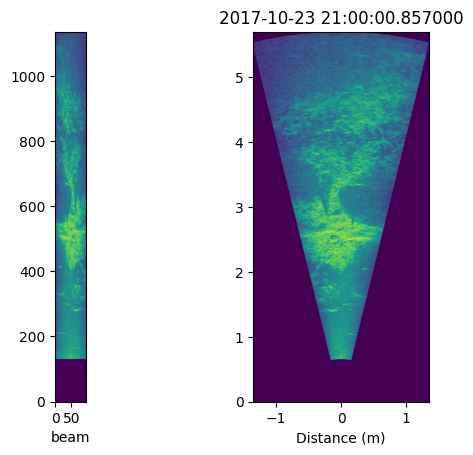

In [3]:
import numpy
import matplotlib.pyplot as plt
import datetime
from PIL import Image
import numpy as np

# absolute path to the java library. The name says tritech, but this also work with ARIS files. 
jpype.addClassPath("C:\\Users\\dg50\\source\\repos\\TritechFiles\\TritechFilesV1002.jar")

# pick a file or folder of files to test. 
# some example ARIS files are available at 
# https://figshare.com/articles/dataset/ARIS_dataset_Three_fish_species/14423630?file=29131479
#sampleFile = "E:\\GLFYear6\\Trip2\\20251217\\log_2025-12-17-000335.glf"
sampleFile = "C:\\Users\\dg50\\Downloads\\A Salmon (1).aris"
sampleFolder = "E:\\GLFYear6\\Trip2\\20251217"

# create the Java object that can turn the rectangular image into a fan image
# this only needs to be made once, though if using multiple sonars, it's good
# to have one per sonar. The fan maker holds a lot of translation data in lookup
# tables which will automatically rebuild whenever sonar dimensions change, so 
# it gets quite inefficient it two sonars with even slightly different frame sizes use
# the same fan maker. 
fanMaker = JClass('tritechgemini.imagedata.FanPicksFromData')(4)
# to make the file catalog you can either pass a single file or a 
# folder name to the catalogFiles function of a MultiFileCatalog. 
# If you go for a folder, then all files are catalogued and the catalogue
# offers rapid access to any frame in any file. 
# so you can do your own loop over files and catalog them one at a time, then loop through that 
# files records, or you can do the whole lot in one go. The choice is yours. The catalog will
# handle Tritech glf and ecd files and ARIS aris files. Note that all returned records are 
# subclasses of GeminiImageRecordI and all have the same basic information, but details may 
# vary depending on file type. 
str = java.lang.String(sampleFile) # turn the file path into a Java string. 
mfc = JClass('tritechgemini.fileio.MultiFileCatalog')() # create the catalogue object
mfc.catalogFiles(str, java.lang.Boolean(True)) # catalogue files within the object. 
nRec = mfc.getTotalRecords() # get and print the total number of records in the catalogue. 
print('Number of records in file is ', nRec)

## here is where you would start a loop over all records if that was your thing. 
# read the first record
aRec = mfc.getRecord(0)
#print(aRec);
# get the basic dimensions
nBeam = aRec.getnBeam() #number of beams
nRange = aRec.getnRange() # number of ranges
maxRange = aRec.getMaxRange() # max range in metres. 
bearingTable = aRec.getBearingTable()
# get the image data from the record. Remember to get this as short not the byte data (unless you're prepared to convert -ve values)
imageData = aRec.getShortImageData()
# convert to a numpy array.
pData = numpy.array(imageData)
# reshape the one dimensional array into 2D
gridData = pData.reshape(nRange, nBeam)
# now use other functions in the Java library to create a fan image
fanImage = fanMaker.createFanData(aRec, 1000)
fanData = numpy.array(fanImage.getImageValues()).transpose()
shape = numpy.shape(fanData); # gives height and width
xExtent = fanImage.getMetresPerPixX()*shape[1]
yExtent = fanImage.getMetresPerPixY()*shape[0]

# now !!IMPORTANT!! free the raw data or we'll eventually run out of memory
aRec.freeImageData()

# plot the data as both the rectangular image of the raw data and as the fan. 
plt.subplot(1,2,1)
plt.imshow(gridData, origin='lower')
plt.xlabel("beam")
plt.subplot(1,2,2)
plt.imshow(fanData, origin='lower', extent=(-xExtent/2, xExtent/2, 0, yExtent))
plt.xlabel('Distance (m)')
dt = datetime.datetime.fromtimestamp(aRec.getRecordTime()/1000.0)
plt.title(dt);

# save the images in files
#print(np.max(gridData))
nGrid = (gridData-np.min(gridData))/(np.max(gridData)-np.min(gridData))*256
im = Image.fromarray(np.flipud(nGrid));
im = im.convert('RGB')
im.save("rawimage2.jpeg")

nGrid = (fanData-np.min(fanData))/(np.max(fanData)-np.min(fanData))*256
im = Image.fromarray(np.flipud(nGrid));
im = im.convert('RGB')
im.save('fanimage2.jpeg')

In [ ]:
shutdownJVM()